In [2]:
from mesa import Agent, Model

from mesa.time import RandomActivation

from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

In [3]:
class Coche(Agent):
    def __init__(self, unique_id, model, x, y, orientation):
        super().__init__(unique_id, model)
        
        # Posición del coche
        self.position = np.array((x,y), dtype=np.float64)
        
        # Orientación del coche
        self.orientation = orientation
        
        # Vector de velocidad y aceleración del coche
        self.check_speed()
        
    def step(self):
        self.check_limits()
        self.turn()
        self.check_speed()
        
        self.position = self.position + self.velocity
        #self.velocity = self.velocity + self.acceleration

    def check_speed(self):
        # Horizontal de derecha a izquierda
        if self.orientation == 'right-left':
            vel = -1
            #acc = vel/2
            self.velocity = np.array((vel, 0), dtype=np.float64)
            #self.acceleration = np.array((acc, 0), dtype=np.float64)
            
        # Vertical de arriba hacia abajo
        elif self.orientation == 'up-down':
            vel = -1
            #acc = vel/2
            self.velocity = np.array((0, vel), dtype=np.float64)
            #self.acceleration = np.array((0, acc), dtype=np.float64)
        
        # Horizontal de izquierda a derecha
        elif self.orientation == 'left-right':
            vel = 1
            #acc = vel/2
            self.velocity = np.array((vel, 0), dtype=np.float64)
            #self.acceleration = np.array((acc, 0), dtype=np.float64)
            
        # Vertical de abajo hacia arriba
        elif self.orientation == 'down-up':
            vel = 1
            #acc = vel/2
            self.velocity = np.array((0, vel), dtype=np.float64)
            #self.acceleration = np.array((0, acc), dtype=np.float64)
            
    def check_limits(self):
        if self.position.flatten()[0] > 20:
            self.position[0] = -10
        elif self.position.flatten()[0] < -20:
            self.position[0] = 10
            
        if self.position.flatten()[1] > 20:
            self.position[1] = -10
        elif self.position.flatten()[1] < -20:
            self.position[1] = 10
        
    def turn(self):
        if self.position[0] == -3 or self.position[0] == 3 and self.position[1] == -3.0 or self.position[1] == 3.0:
            direction = np.random.choice(["forward", "right"])
            if direction == 'right' :
                self.position = self.position + self.velocity
                if self.orientation == 'right-left' :
                    self.orientation = 'down-up'
                elif self.orientation == 'up-down' :
                    self.orientation = 'right-left'
                elif self.orientation == 'left-right' :
                    self.orientation = 'up-down'
                elif self.orientation == 'up-down' :
                    self.orientation = 'right-left'
                self.check_speed()
                self.position = self.position + self.velocity
                self.position = self.position + self.velocity
    
    

In [4]:
def get_cars(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

class CarModel(Model):
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        
        source = np.array([[10, 0], [10, 2], [0, 10], [-2, 10], [-10, 0], [-10, -2], [0, -10], [2, -10]])
        temp = []
        i = 0
        
        while i in range(self.num_agents):
            pos = np.random.randint(8)
            if pos in temp:
                continue
            x = source[pos][0]
            y = source[pos][1]
            orientation = self.initial_orientation(pos)
            a = Coche(i, self, x, y, orientation)
            self.schedule.add(a)
            
            temp.append(pos)
            i += 1
            
        self.datacollector = DataCollector(model_reporters = {"Coches" : get_cars})
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        
    def initial_orientation(self, pos):
        if 0 <= pos <= 1:
            return 'right-left'
        elif 2 <= pos <= 3:
            return 'up-down'
        elif 4 <= pos <= 5:
            return 'left-right'
        elif 6 <= pos <= 7:
            return 'down-up'
            

In [9]:
MAX_GENERATIONS = 20
N = 5

model = CarModel(N)

for i in range(MAX_GENERATIONS):
    model.step()

In [10]:
all_positions = model.datacollector.get_model_vars_dataframe()

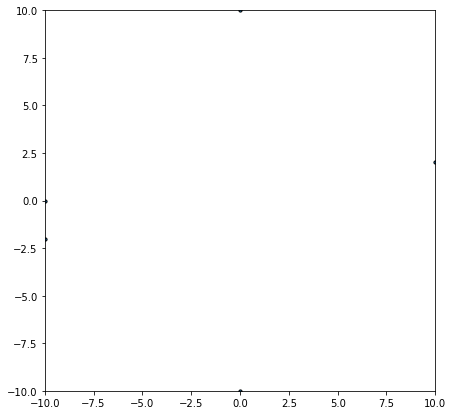

In [11]:
fig, ax = plt.subplots(figsize=(7,7))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1],
                     s=10, cmap="jet", edgecolor="k")
ax.axis([-10, 10, -10, 10])
def update(frame_number):
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    return scatter

anim = animation.FuncAnimation(fig, update, frames = MAX_GENERATIONS)

In [12]:
anim